# <span style="color:orange"> **Anime 1: Estimación de ratings en animes**

## <span style="color:#87CEEB"> **1.- Resumen**
### <span style="color:#87CEEB"> Resumen del caso: La empresa nos pide crear un sistema que ayude aestimar el puntaje que una serie/película debería tener dadas sus características.

    Vector Objetivo: Variable 'rating'.

    Data set usado en el modelo: df_anime.

    1. anime.csv (caracteristicas de los animes)
        * anime_id: Identificador único del anime.
        * name: Nombre completo del anime.
        * genre: Lista de géneros (separados por coma) en el que califica el anime.
        * type: Tipo de presentación del anime, puede ser: movie, TV, OVA, etc.
        * episodes: Número de episodios del anime (1 para el caso películas).
        * rating: Evaluación promedio del anime.
        * members: Número de miembros de la comunidad que están en el “grupo” del anime.

## <span style="color:#87CEEB"> **2.- Aspectos computacionales**

### <span style="color:#87CEEB"> 2.1.- Librerías

In [1]:
# Ingesta
import numpy as np
import pandas as pd
import scipy.stats as stats

# Preprocesamiento
from sklearn.impute import SimpleImputer

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

# Modelación
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

# Métricas de evaluación
from sklearn.metrics import mean_absolute_error, r2_score

# Otros
import pickle
import warnings
warnings.filterwarnings("ignore")

### <span style="color:#87CEEB"> 2.2.- Funciones

In [2]:
def estudio_nulos(data, simbolo):
    ''' 
    [resumen]: Imprime cantidad de datos perdidos en cada columna y devuelve listas,
                todo en base al símbolo proporcionado
    [data]: DataFrame
    [simbolo]: Carácter, string, valor a buscar como nulo o perdido
    [return]: lista_sin_vacios, lista_con_vacios
    '''
    lista_sin_vacios = []
    lista_con_vacios = []
    for i in data.columns:
        try:
            print(f'{i}: {data[i].value_counts()[simbolo]}')
            lista_con_vacios.append(i)
        except:
            lista_sin_vacios.append(i)
    return lista_sin_vacios, lista_con_vacios

In [3]:
# conteo de np.nan
def porcentaje_nulos(data, lista_nulos):
    ''' 
    Ingresa una data y una lista de columnas
    para imprimir los % de nan por columnas, y el total por líneas       
    '''
    print('Porcentaje de nulos:')
    print('-'*28)
    for col in lista_nulos:
        nulos = data[col].isnull().value_counts('%')
        try:
            nulos = nulos[True]*100
            print(f'{col}: {np.round(nulos, 4)} %')
        except:
            print(f'{col}: No contiene nulos')

    tmp_drop = data.dropna().copy()
    porcion_nulos = (1-(tmp_drop.shape[0]/data.shape[0]))*100
    print('-'*28, f'\nPorcentaje total de nulos en el dataset: {np.round(porcion_nulos, 4)} %')

In [4]:
# ajuste de modelos, predicciones y métricas
def probar_modelos(modelo, X, y):
    '''
    [resumen]: modela, predice e imprime resultados MAE y R2
    [modelo]: modelo de sklearn
    [X]: matriz de atributos
    [y]: Vector objetivo
    [return]: none 
    '''
    modelo_fit = modelo.fit(X, y)
    y_hat = modelo_fit.predict(X)

    print(f'{modelo}','\n',
        f'MAE: {mean_absolute_error(y_true=y, y_pred=y_hat)}','\n',
        f'R2: {r2_score(y_true=y, y_pred=y_hat)}', '\n', '-'*50)

## <span style="color:#87CEEB"> **3.- Ingeniería de Datos**

### <span style="color:#87CEEB"> 3.1.- Importación de datos

In [20]:
# importación de base de datos
df = pd.read_csv('/Users/elio1/Dataset_csv/anime.csv', delimiter=';')

In [21]:
# Visualización simple de dataframe
display(df.head())
df.shape

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,"9,37",200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,"9,26",793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,"9,25",114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,"9,17",673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,"9,16",151266


(12294, 7)

### <span style="color:#87CEEB"> 3.2.- Comportamiento del vector objetivo

In [22]:
# tipo de dato
df['rating'].dtypes

dtype('O')

    El vector objetivo presenta valores numéricos pero su tipo de dato es 'objeto'.

In [24]:
# visualización de algunos valores del vector objetivo
df['rating'].unique()[:20]

array([' 9,37', ' 9,26', ' 9,25', ' 9,17', ' 9,16', ' 9,15', ' 9,13',
       ' 9,11', ' 9,10', ' 9,06', ' 9,05', ' 9,04', ' 8,98', ' 8,93',
       ' 8,92', ' 8,88', ' 8,84', ' 8,83', ' 8,82', ' 8,81'], dtype=object)

In [25]:
# cantidad de valores únicos en el vector objetivo
len(df['rating'].unique())

599

In [26]:
# tranformación de tipo de dato de 'str' a 'float'
df['rating'] = df['rating'].str.replace(',', '.').astype(float)

# Comprobación de transformación correcta
df['rating'].unique()[:10]

array([9.37, 9.26, 9.25, 9.17, 9.16, 9.15, 9.13, 9.11, 9.1 , 9.06])

#### <span style="color:orange"> Cantidad de nulos en el vector objetivo

In [27]:
# cantidad de datos nulos en vector objetivo
print('Cantidad:\n', df['rating'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['rating'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    12064
True       230
Name: rating, dtype: int64 
 ------------------------------
Porcentaje:
 False    98.13
True      1.87
Name: rating, dtype: float64


    Se observa que el vector objetivo presenta 230 valores nulos. Estos serán separados del dataframe original y se utilizarán más adelante como muestra a predecir una vez se haya encontrado un modelo eficaz.
    En etapas posteriores se realizará este proceso.

#### <span style="color:orange"> Distribución del vector objetivo

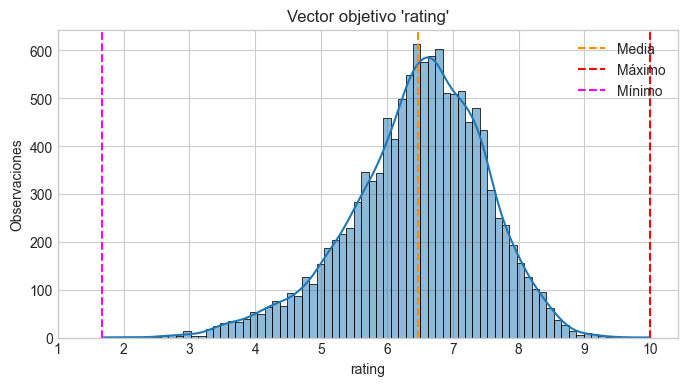

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(df['rating'], kde=True)
plt.axvline(df['rating'].mean(), color='darkorange', linestyle='--', label='Media')
plt.axvline(df['rating'].max(), color='red', linestyle='--', label='Máximo')
plt.axvline(df['rating'].min(), color='magenta', linestyle='--', label='Mínimo')
plt.legend(loc='upper right')
plt.title("Vector objetivo 'rating'")
plt.ylabel('Observaciones')
plt.xticks(range(1, 11));

In [33]:
x = stats.mode(df['rating'])

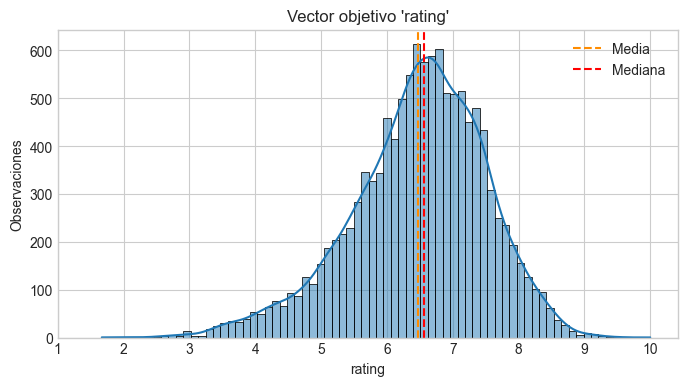

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(df['rating'], kde=True)
plt.axvline(df['rating'].mean(), color='darkorange', linestyle='--', label='Media')
plt.axvline(df['rating'].median(), color='red', linestyle='--', label='Mediana')
#plt.axvline(stats.mode(x), color='magenta', linestyle='--', label='Moda')
plt.legend(loc='upper right')
plt.title("Vector objetivo 'rating'")
plt.ylabel('Observaciones')
plt.xticks(range(1, 11));

    Se observa una distribución de las valoraciones similar a la normal, con una leve tendencia a puntajes sobre la media.

##### <span style="color:orange"> Estadísticas descriptivas del vector objetivo

In [13]:
df['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

### <span style="color:#87CEEB"> 3.3.- Comportamiento de los atributos

#### <span style="color:#87CEEB"> 3.3.1.- Variable 'name'

##### <span style="color:orange"> Cantidad de nombres de anime

In [14]:
# Cantidad de nombres de anime
print('Cantidad total de observaciones en name:', len(df['name']))
print('Cantidad de valores únicos en name:', len(df['name'].unique()))
df['name'].value_counts()

Cantidad total de observaciones en name: 12294
Cantidad de valores únicos en name: 12292


Shi Wan Ge Leng Xiaohua                           2
Saru Kani Gassen                                  2
Bakabon Osomatsu no Karee wo Tazunete Sansenri    1
Backkom Meogeujan Yeohaeng                        1
Backkom Mission Impossible                        1
                                                 ..
Yoroiden Samurai Troopers Kikoutei Densetsu       1
Yuu☆Yuu☆Hakusho: Mu Mu Hakusho                    1
3-gatsu no Lion meets Bump of Chicken             1
Bannou Bunka Neko-Musume                          1
Yasuji no Pornorama: Yacchimae!!                  1
Name: name, Length: 12292, dtype: int64

In [15]:
display(df[df['name'] == 'Shi Wan Ge Leng Xiaohua'])
display(df[df['name'] == 'Saru Kani Gassen'])

,anime_id,name,genre,type,episodes,rating,members
10193,33193,Shi Wan Ge Leng Xiaohua,"Comedy, Parody",ONA,12,6.67,114
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


,anime_id,name,genre,type,episodes,rating,members
10140,22399,Saru Kani Gassen,Kids,OVA,1,5.23,62
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76


    Se observa que 'Shi Wan Ge Leng Xiaohua' y 'Saru Kani Gassen' tienen dos observaciones cada uno, pero se diferencian en el tipo de anime. Debido a esto el atributo 'name' tiene una cantidad total de 12294 observaciones pero 12292 valores únicos.

##### <span style="color:orange"> Cantidad de nulos en 'name'

In [16]:
# cantidad de datos nulos en 'name'
print('Cantidad:\n', df['name'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['name'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    12294
Name: name, dtype: int64 
 ------------------------------
Porcentaje:
 False    100.0
Name: name, dtype: float64


    No existen datos nulos en la variable 'name'.

#### <span style="color:#87CEEB"> 3.3.2.- Variable 'genre'

##### <span style="color:orange"> Géneros únicos de anime

In [17]:
df['genre'].str.get_dummies(', ').columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dark Fantasy', 'Dementia',
       'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Idol', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Sclice of Life', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

    Al separar de manera independiente todos los géneros existentes, se observa que existe una discrepancia para 'Slice of Life'. Es por esto que se implementa una recodificación para corregir este error.

In [18]:
# recodificación de 'Slice of Life'
df['genre'] = df['genre'].str.replace('Sclice of Life', 'Slice of Life')

# Comprobación de correcta recodificación
df['genre'].str.get_dummies(', ').columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dark Fantasy', 'Dementia',
       'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Idol', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

##### <span style="color:orange"> Combinaciones de géneros de anime

In [19]:
# cantidad de combinaciones de géneros
print('Cantidad de combinaciones de géneros:\n', len(df['genre'].value_counts()))
df['genre'].value_counts()

Cantidad de combinaciones de géneros:
 3271


Hentai                                                    823
Comedy                                                    523
Music                                                     302
Kids                                                      199
Comedy, Slice of Life                                     179
                                                         ... 
Historical, Mystery                                         1
Drama, Fantasy, Mystery, Romance, Supernatural              1
Comedy, Magic, Parody, Police, Sci-Fi, Shounen, Space       1
Action, Comedy, Fantasy, Martial Arts, Shounen, Sports      1
Hentai, Slice of Life                                       1
Name: genre, Length: 3271, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'genre'

In [20]:
# cantidad de datos nulos en 'genre'
print('Cantidad:\n', df['genre'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['genre'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    12247
True        47
Name: genre, dtype: int64 
 ------------------------------
Porcentaje:
 False    99.62
True      0.38
Name: genre, dtype: float64


    Existen 47 datos nulos en 'genre' lo que equivale a 0.38% del total de datos.

#### <span style="color:#87CEEB"> 3.3.3.- Variable 'type'

##### <span style="color:orange"> Tipos únicos de anime

In [21]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

##### <span style="color:orange"> Cantidad de tipos de anime

In [22]:
df['type'].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'type'

In [23]:
# cantidad de datos nulos en 'type'
print('Cantidad:\n', df['type'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['type'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    12269
True        25
Name: type, dtype: int64 
 ------------------------------
Porcentaje:
 False    99.8
True      0.2
Name: type, dtype: float64


    Existen 25 datos nulos en 'type' lo que equivale a 0.2% del total de datos.

#### <span style="color:#87CEEB"> 3.3.4.- Variable 'episodes'

##### <span style="color:orange"> Tipo de dato de 'episodes'

In [24]:
display(df['episodes'].dtype)
df['episodes'].values

dtype('O')

array(['1', '64', '51', ..., '4', '1', '1'], dtype=object)

In [25]:
df['episodes'][df['episodes'] == 'Unknown'].value_counts()

Unknown    340
Name: episodes, dtype: int64

    Se observó que el tipo de dato es 'str' y que además existe el valor 'Unknown'. Dado lo anterior se procede a cambiar el tipo de dato y recodificar los valores 'Unknown' como np.nan

In [26]:
# Recodificación de 'Unknown' y transformación del tipo de dato
df['episodes'] = np.where(df['episodes'] == 'Unknown', np.nan, df['episodes'])
df['episodes'] = df['episodes'].astype(float)

##### <span style="color:orange"> Estadísticas descriptivas de 'episodes'

In [27]:
df['episodes'].describe().round(2)

count    11954.00
mean        12.38
std         46.87
min          1.00
25%          1.00
50%          2.00
75%         12.00
max       1818.00
Name: episodes, dtype: float64

##### <span style="color:orange"> Frecuencia de cantidad de episodios de anime

In [28]:
df['episodes'].value_counts()

1.0      5677
2.0      1076
12.0      816
13.0      572
26.0      514
         ... 
330.0       1
291.0       1
276.0       1
120.0       1
125.0       1
Name: episodes, Length: 186, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'episodes'

In [29]:
# cantidad de datos nulos en 'episodes'
print('Cantidad:\n', df['episodes'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['episodes'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    11954
True       340
Name: episodes, dtype: int64 
 ------------------------------
Porcentaje:
 False    97.23
True      2.77
Name: episodes, dtype: float64


#### <span style="color:#87CEEB"> 3.3.5.- Variable 'members'

##### <span style="color:orange"> Tipo de dato de 'members'

In [30]:
display(df['members'].dtype)
df['members'].values

dtype('int64')

array([200630, 793665, 114262, ...,    219,    175,    142], dtype=int64)

##### <span style="color:orange"> Estadísticas descriptivas de 'members'

In [31]:
df['members'].describe().round(2)

count      12294.00
mean       18071.34
std        54820.68
min            5.00
25%          225.00
50%         1550.00
75%         9437.00
max      1013917.00
Name: members, dtype: float64

##### <span style="color:orange"> Cantidad de nulos en 'members'

In [32]:
# cantidad de datos nulos en 'members'
print('Cantidad:\n', df['members'].isna().value_counts(),'\n','-'*30)
print('Porcentaje:\n', df['members'].isna().value_counts('%').round(4)*100)

Cantidad:
 False    12294
Name: members, dtype: int64 
 ------------------------------
Porcentaje:
 False    100.0
Name: members, dtype: float64


## <span style="color:#87CEEB"> **4.- Tratamiento de datos nulos**

### <span style="color:#87CEEB"> 4.1.- Imputación de nulos

#### <span style="color:#87CEEB"> 4.1.1.- Porcentaje de nulos en el dataset

In [33]:
# porcentaje de nulos en las variables
porcentaje_nulos(df, df.columns)

Porcentaje de nulos:
----------------------------
anime_id: No contiene nulos
name: No contiene nulos
genre: 0.3823 %
type: 0.2034 %
episodes: 2.7656 %
rating: 1.8708 %
members: No contiene nulos
---------------------------- 
Porcentaje total de nulos en el dataset: 3.7742 %


#### <span style="color:#87CEEB"> 4.1.2.- Imputación de nulos por la moda o más frecuente.

In [34]:
df_imputado = df.drop('rating', axis=1).fillna(df.drop('rating', axis=1).mode().iloc[0])
df_imputado = pd.concat([df_imputado, df['rating']], axis=1)
df_imputado.head()

,anime_id,name,genre,type,episodes,members,rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,200630,9.37
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,793665,9.26
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,114262,9.25
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,673572,9.17
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,151266,9.16


In [35]:
# verificación de correcta imputación
porcentaje_nulos(df_imputado, df.columns)

Porcentaje de nulos:
----------------------------
anime_id: No contiene nulos
name: No contiene nulos
genre: No contiene nulos
type: No contiene nulos
episodes: No contiene nulos
rating: 1.8708 %
members: No contiene nulos
---------------------------- 
Porcentaje total de nulos en el dataset: 1.8708 %


### <span style="color:#87CEEB"> 4.2.- Separación de nulos en el vector objetivo

In [36]:
# matriz que contiene todas las columnas pero solo considera aquellas en que el vector objetivo contiene datos nulos
df_test_nulos = df_imputado[df_imputado['rating'].isna()]
df_test_nulos.shape

(230, 7)

### <span style="color:#87CEEB"> 4.3.- Eliminación de datos nulos

In [37]:
df_clean = df_imputado.dropna()

In [38]:
df_clean.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes    float64
members       int64
rating      float64
dtype: object

## <span style="color:#87CEEB"> **5.- Creación de dataset para modelar**

### <span style="color:#87CEEB"> 5.1.- One-Hot Encoding (OHE) para atributos 'genre' y 'type'

In [39]:
df_dummies = pd.get_dummies(df_clean[['genre','type']])

### <span style="color:#87CEEB"> 5.2.- Dataset

In [40]:
df_ep_mem = df_clean.loc[:, ['episodes', 'members']]

In [41]:
# dataset para modelar
df_modelo = pd.concat([df_ep_mem, df_dummies], axis=1)
df_modelo.head()

,episodes,members,genre_Action,"genre_Action, Adventure","genre_Action, Adventure, Cars, Comedy, Sci-Fi, Shounen","genre_Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports","genre_Action, Adventure, Cars, Sci-Fi","genre_Action, Adventure, Comedy","genre_Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi","genre_Action, Adventure, Comedy, Demons, Fantasy, Magic",...,genre_Supernatural,genre_Thriller,genre_Vampire,genre_Yaoi,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,1.0,200630,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,64.0,793665,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,51.0,114262,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,24.0,673572,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,51.0,151266,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12064 entries, 0 to 12293
Columns: 3237 entries, episodes to type_TV
dtypes: float64(1), int64(1), uint8(3235)
memory usage: 37.5 MB


## <span style="color:#87CEEB"> **6.- Modelación**

### <span style="color:#87CEEB"> 6.1.- Primera iteración de modelos

In [43]:
# vector objetivo
y = df_clean['rating']

In [48]:
# lista de modelos a implementar
models_list = [
    ElasticNetCV(),
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),  
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]

In [49]:
for model in models_list:
    probar_modelos(model, df_modelo, y)

ElasticNetCV() 
 MAE: 0.7319897606271878 
 R2: 0.15009934505407063 
 --------------------------------------------------
LinearRegression() 
 MAE: 0.4592684421505512 
 R2: 0.5667542337598097 
 --------------------------------------------------
SVR() 
 MAE: 0.6049342881128335 
 R2: 0.373162852754337 
 --------------------------------------------------
DecisionTreeRegressor() 
 MAE: 0.020719385499557916 
 R2: 0.980744261877879 
 --------------------------------------------------
RandomForestRegressor() 
 MAE: 0.1962678903496619 
 R2: 0.9207890758792078 
 --------------------------------------------------
AdaBoostRegressor() 
 MAE: 0.7223560914740672 
 R2: 0.23969687461194078 
 --------------------------------------------------
GradientBoostingRegressor() 
 MAE: 0.5007250878361157 
 R2: 0.5706302446576867 
 --------------------------------------------------


### <span style="color:#87CEEB"> 6.2.- Voting Regressor

In [50]:
estimadores = [
        ('Linear_Regression',LinearRegression()),
        ('Decision_Tree_Regressor',DecisionTreeRegressor()),
        ('Random_Forest_Regressor',RandomForestRegressor()),
        ('Gradient_Boosting_Regressor',GradientBoostingRegressor())
        ]

In [51]:
voting_model = VotingRegressor(estimators=estimadores,
                                verbose=True,
                                n_jobs=-1
                                )

In [52]:
probar_modelos(voting_model, df_modelo, y)

VotingRegressor(estimators=[('Linear_Regression', LinearRegression()),
                            ('Decision_Tree_Regressor',
                             DecisionTreeRegressor()),
                            ('Random_Forest_Regressor',
                             RandomForestRegressor()),
                            ('Gradient_Boosting_Regressor',
                             GradientBoostingRegressor())],
                n_jobs=-1, verbose=True) 
 MAE: 0.27025434854196473 
 R2: 0.8612560904359324 
 --------------------------------------------------


### <span style="color:#87CEEB"> 6.3.- Selección de modelos
        * LinearRegression()
        * DecisionTreeRegressor()
        * RandomForestRegressor()
        * GradientBoostingRegressor()
        * VotingRegressor()

# NOTAS:
    Esto dijo el profe:
    - mae no mayor a 10
    - r2 mayor a 10 
    - rmse comparar con otros modelos. 